# Purpose
The point of this notebook is to demonstrate how to perform permutation-based, visual, conditional independence tests.

In particular, the notebook will show one way to visually and numerically test the following implication<br>
$
\begin{aligned}
P \left( X_1 \mid X_2, Z \right) &= P \left( X_1 \mid Z \right) \\
\int x_1 P \left( X_1 \mid X_2, Z \right) \partial{x_1}  &= \int x_1 P \left( X_1 \mid Z \right) \partial{x_1} \\
E \left[ X_1 \mid X_2, Z \right] &= E \left[ X_1 \mid Z \right]
\end{aligned}
$

In other words, if $X_1$ is conditionally independent of $X_2$ given $Z$, then the expectation of $X_1$ conditional on $X_2$ and $Z$ is equal to the expectation of $X_1$ conditional on just $Z$.
This implies that shuffling / permuting $X_2$ should make no difference for predicting $X_1$ once we've included $Z$ while predicting.

In other words, one's ability predict to predict $X_1$ should not depend on whether one uses the original $X_2$ or the permuted $X_2$, as long as one conditions on $Z$ when predicting $X_1$.
This invariance will be tested by using a simple predictive model, linear regression, and comparing $r^2$ as a measure of predictive ability when using $Z$ and the original $X_2$ versus $r^2$ when using $Z$ and the permuted $X_2$.

In [1]:
# Declare hyperparameters for testing
MIN_SAMPLES_LEAF = 40
NUM_PERMUTATIONS = 100

# Declare the columns to be used for testing
x1_col = 'total_travel_time'
x2_col = 'total_travel_cost'
z_col = 'total_travel_distance'
mode_id_col = 'mode_id'

# Set the colors for plotting
permuted_color = '#a6bddb'

# Declare paths to data
DATA_PATH =\
    '../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv'

In [2]:
import sys

import numpy as np
import pandas as pd
from scipy.stats import multinomial

import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

sys.path.insert(0, '../../src/')
import testing.conditional_independence as ci

In [3]:
# Load the raw data
df = pd.read_csv(DATA_PATH)

100%|██████████| 100/100 [00:00<00:00, 859.56it/s]

total_travel_time vs total_travel_cost, 
conditional on total_travel_distance

The p-value of the permutation C.I.T. is 0.00.


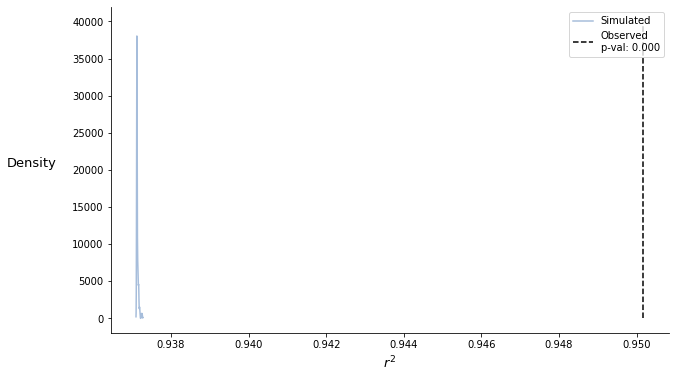

0.0

In [4]:
title_str = '{} vs {}, \nconditional on {}\n'
print(title_str.format(x1_col, x2_col, z_col))

drive_alone_filter = df[mode_id_col] == 1
time_array = df.loc[drive_alone_filter, x1_col].values
cost_array = df.loc[drive_alone_filter, x2_col].values
distance_array = df.loc[drive_alone_filter, z_col].values

ci.visual_permutation_test(
    time_array, cost_array, distance_array,
    num_permutations=NUM_PERMUTATIONS,
    permutation_color=permuted_color)

100%|██████████| 100/100 [00:00<00:00, 934.35it/s]

total_travel_cost vs cross_bay, 
conditional on total_travel_distance

The p-value of the permutation C.I.T. is 0.00.


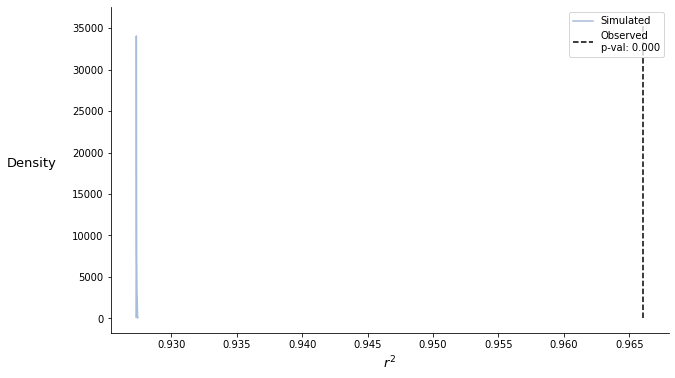

0.0

In [5]:
new_x1_col = 'total_travel_cost'
new_x2_col = 'cross_bay'

drive_alone_filter = df[mode_id_col] == 1
cost_array = df.loc[drive_alone_filter, new_x1_col].values
cross_bay_array = df.loc[drive_alone_filter, new_x2_col].values
distance_array = df.loc[drive_alone_filter, z_col].values


title_str = '{} vs {}, \nconditional on {}\n'
print(title_str.format(new_x1_col, new_x2_col, z_col))

ci.visual_permutation_test(
    cost_array, cross_bay_array, distance_array,
    num_permutations=NUM_PERMUTATIONS,
    permutation_color=permuted_color)

## Test `visual_permutation_test`

The test below tries to check that the p-values derived from `visual_permutation_test` fit the criteria of a classical (i.e. frequentist) test statistic. In other words, the test below checks to see whether the p-values derived from `visual_permutation_test` are approximately uniformly distributed under the null-hypothesis. See https://jrnold.github.io/bayesian_notes/model-checking.html#posterior-predictive-checks (Section 9.2.3) for more information.

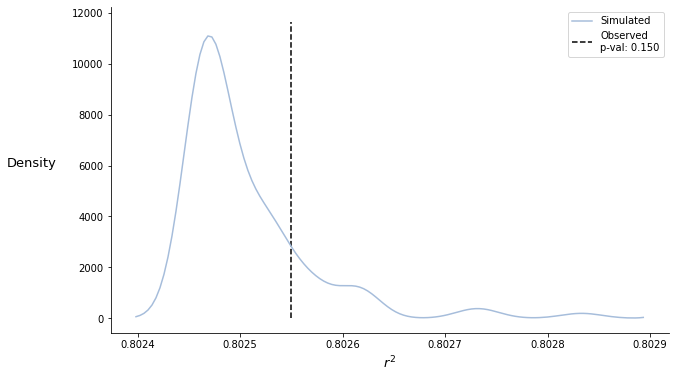

In [6]:
# Figure out how many observations to simulate, based on real data
num_drive_alone_obs = (df.mode_id == 1).sum()
# Determine how many simulations to carry out
NUM_TEST_SIM = 200

# Initialize an array to store the simulated p-values
test_p_vals = np.empty((NUM_TEST_SIM,), dtype=float)

# Set a random seed for reproducibility
np.random.seed(340)

# Compute the p-values of the visual permutation test when the
# null-hypothesis is true.
for i in tqdm(range(NUM_TEST_SIM)):
    # Simulate data that, by construction, satisfies x2 indep x1 given z
    sim_z = np.random.normal(size=num_drive_alone_obs)
    sim_x1 = sim_z + 0.5 * np.random.normal(size=num_drive_alone_obs)
    sim_x2 = sim_z - 0.01 * np.random.uniform(size=num_drive_alone_obs)

    # Determine which simulations to plot.
    # Just plot 1 simulation for visual comparison with real data
    current_close = True if i != 0 else False

    # Carry out the permutation test
    current_p =\
        ci.visual_permutation_test(
             sim_x1,
             sim_x2,
             sim_z,
             num_permutations=NUM_PERMUTATIONS,
             seed=None,
             progress=False,
             verbose=False,
             permutation_color=permuted_color,
             show=False,
             close=current_close)
    # Store the resulting p-values
    test_p_vals[i] = current_p

### Perform a visual test of `visual_permutation_test`

/Users/timothyb0912/anaconda/envs/replicaAssgnmt/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


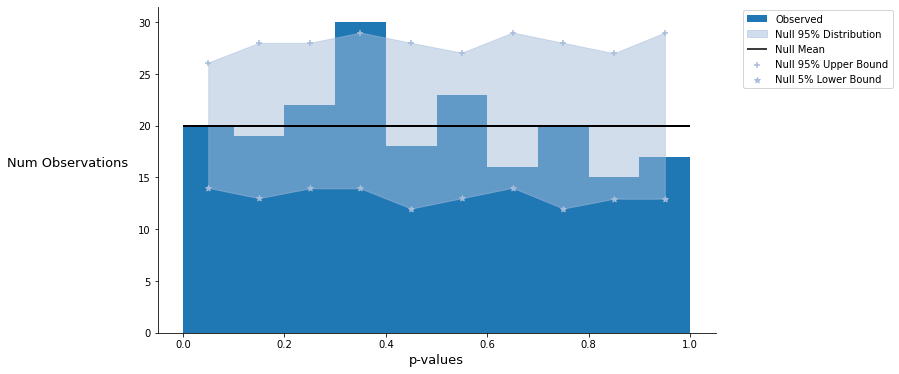

In [7]:
# Create a distribution of p-values that is for sure are uniformly distributed
null_histogram_dist = multinomial(NUM_TEST_SIM, [0.1 for x in range(10)])

null_hist_samples = null_histogram_dist.rvs(100)
null_hist_mean = null_histogram_dist.mean()
null_hist_upper_bound = np.percentile(null_hist_samples, 95, axis=0)
null_hist_lower_bound = np.percentile(null_hist_samples, 5, axis=0)

# Plot the distribution of our test p-values versus the p-values from
# a uniform distriburtion
fig, ax = plt.subplots(figsize=(10, 6))

plot_categories = [0.05 + 0.1 * x for x in range(10)]
ax.fill_between(plot_categories,
                null_hist_upper_bound,
                null_hist_lower_bound,
                color=permuted_color,
                label='Null 95% Distribution',
                alpha=0.5,
                zorder=2)

ax.hlines(null_hist_mean, 0, 1, label='Null Mean')

ax.hist(test_p_vals, bins=10, label='Observed', zorder=0)

ax.scatter(
    plot_categories,
    null_hist_upper_bound,
    label='Null 95% Upper Bound',
    color=permuted_color,
    marker='+',
    zorder=1)

ax.scatter(
    plot_categories,
    null_hist_lower_bound,
    label='Null 5% Lower Bound',
    color=permuted_color,
    marker='*',
    zorder=1)

ax.legend(loc=(1.05, 0.75))
ax.set_xlabel('p-values', fontsize=13)
ax.set_ylabel('Num Observations', rotation=0, labelpad=70, fontsize=13)

sbn.despine()
fig.show()

### Perform a computational / programmatic test of `visual_permutation_test`

In [8]:
# Figure out the number of p-values per bin
bin_edges = [0.1 * x for x in range(11)]
test_p_values_per_bin =\
    np.histogram(test_p_vals, bins=bin_edges)[0]

num_p_vals_outside_expectation =\
    ((test_p_values_per_bin > null_hist_upper_bound) +
     (test_p_values_per_bin < null_hist_lower_bound)).sum()

# Given 10 bins, each representing a 95% chance of containing the
# observed number of test_p_vals under the null distribution,
# we would not really expect more than 2 bins to be outside the
# range given by the uniform distribution.
# The probability of 3 bins being outside the range is very low
# scipy.stats.binom(n=10, p=0.05).pmf(3) = 0.0104
assert num_p_vals_outside_expectation <= 2

## Conclusions
- From the last two plots, we can see that under the null hypothesis of $X_1$ independent of $X_2$ given $Z$, we get p-values that close to uniformly distributed.<br>
This means the permutation p-values in `visual_permutation_test` are unlikely to be overly-optimistic.<br>
In other words, we can feel safe(r) about relying on this test to distinguish conditional dependence from independence.
- From the first two plots of this notebook, we can see from applying the `visual_permutation_test` that:
  - travel time and travel cost are not conditionally independent given travel distance.
  - travel cost and `cross_bay` are not conditionally independent given travel distance (as one might expect since one's travel cost is a function of whether or not one pays tolls to cross the Bay Bridge).